In [1]:
import pandas as pd
import os
import cv2
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.linear_model import LogisticRegression

from datetime import datetime
import time

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, accuracy_score, f1_score, recall_score, precision_score
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def get_model_metrics(test_data, model, model_name):
    """
    Evaluates a binary classification model on test data and reports various performance metrics.
    It calculates the confusion matrix, ROC curve, and several statistical measures including accuracy, 
    sensitivity, specificity, precision, NPV (Negative Predictive Value), PLR (Positive Likelihood Ratio), 
    NLR (Negative Likelihood Ratio), and F1-score. Additionally, it identifies the best threshold for 
    classification based on the max sensitivity within a minimum required specificity.

    The function saves the confusion matrix and ROC curve plots in a local directory, and appends the 
    calculated metrics to a CSV file. This file is created if it doesn't exist, or updated if it does.

    Parameters:
    - test_data (iterable): The test dataset, typically a generator or an iterable that yields batches 
      of images and labels.
    - model (keras.Model): The trained Keras model to evaluate.
    - model_name (str): The name of the model, used for saving output files.

    No return value. The function directly prints the calculated metrics and saves the results and plots 
    to the local file system.
    """
    timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
    results_folder = 'results'
    csv_file = f'{results_folder}/model_performance.csv'
    
    if not os.path.exists(results_folder):
        os.makedirs(results_folder)
        
    predicted_probs = model.predict_proba(test_data[0])
    predicted_probs = predicted_probs[:, 1]
    true_labels = test_data[1]
    predicted_labels = model.predict(test_data[0])

    # ROC AUC
    fpr, tpr, thresholds = roc_curve(true_labels, predicted_probs)
    roc_auc = auc(fpr, tpr)
    
    # Calculate max sensitivity where specificity is >= 1 - prevalence
    prevalence = sum(true_labels) / len(true_labels)
    
    max_sensitivity = 0
    for i in range(len(fpr)):
        specificity = 1 - fpr[i]
        if specificity >= 1 - prevalence:
            max_sensitivity = max(max_sensitivity, tpr[i])
    print(f"Max Sensitivity at Specificity >= {1 - prevalence:.2f}: {max_sensitivity:.2f}")
    
    # Confusion Matrix
    threshold_for_max_sensitivity = thresholds[np.argmax(tpr == max_sensitivity)]
    final_predicted_labels = [1 if p > threshold_for_max_sensitivity else 0 for p in predicted_probs]
    
    # Confusion Matrix
    confusion_mtx = confusion_matrix(true_labels, final_predicted_labels)
    # plot the confusion matrix
    f,ax = plt.subplots(figsize=(8, 8))
    sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Purples",linecolor="gray", fmt= '.1f',ax=ax)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.savefig(f'{results_folder}/{model_name}_run_{timestamp}_confusion_matrix.png')
    plt.show()
    
    # Classification report
    report = classification_report(true_labels, final_predicted_labels)
    print(report)

    # calculate additional metrics
    TP = sum((np.array(true_labels) == 1) & (np.array(final_predicted_labels) == 1))
    TN = sum((np.array(true_labels) == 0) & (np.array(final_predicted_labels) == 0))
    FP = sum((np.array(true_labels) == 0) & (np.array(final_predicted_labels) == 1))
    FN = sum((np.array(true_labels) == 1) & (np.array(final_predicted_labels) == 0))

    accuracy = accuracy_score(true_labels, final_predicted_labels)
    sensitivity = recall_score(true_labels, final_predicted_labels)  # recall
    specificity = TN / (TN + FP)
    precision = precision_score(true_labels, final_predicted_labels)  # PPV
    npv = TN / (TN + FN)
    plr = sensitivity / (1 - specificity)
    nlr = (1 - sensitivity) / specificity
    f1_pos_class = f1_score(true_labels, final_predicted_labels)

    # ROC AUC
    fpr, tpr, _ = roc_curve(true_labels, predicted_probs)
    roc_auc = auc(fpr, tpr)
    
    # create a DataFrame and append to the CSV file
    df = pd.DataFrame({
        'Model Name': [model_name],
        f'Max Sensitivity at Specificity {1 - prevalence:.2f}': [max_sensitivity],
        'AUC': [roc_auc],
        'F1-Score Positive Class': [f1_pos_class],
        'Accuracy': [accuracy],
        'Sensitivity': [sensitivity],
        'Specificity': [specificity],
        'PPV': [precision],
        'NPV': [npv],
        'PLR': [plr],
        'NLR': [nlr]
    }).round(2) 
    
    if os.path.exists(csv_file):
        df.to_csv(csv_file, mode='a', header=False, index=False)
    else:
        df.to_csv(csv_file, index=False)

    print(df)

    # plotting and saving ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.savefig(f'{results_folder}/{model_name}_run_{timestamp}_roc_curve.png')
    plt.show()

In [3]:
# Set the path to your data folders
data_folder = "../../../Data/PRE/cropped_images"
train_folder = os.path.join(data_folder, "cropped_train")
test_folder = os.path.join(data_folder, "cropped_test")
validation_folder = os.path.join(data_folder, "cropped_validation")

# Extract HOG features

In [4]:
def extract_features(image_path):
    image = cv2.imread(image_path, 0)  # Read the image in grayscale
    
    try:
        resized_img = cv2.resize(image, (128, 64))
    except:
        resized_img = image
    
    # Create an HOG descriptor with some parameters
    win_size = (128, 64)
    block_size = (16, 16)
    block_stride = (8, 8)
    cell_size = (8, 8)
    n_bins = 9  # Number of bins for HOG descriptors

    hog = cv2.HOGDescriptor(win_size, block_size, block_stride, cell_size, n_bins)
    
    features = hog.compute(resized_img)
    features = features.flatten()
    
    return features

def load_data(folder):
    data = []
    labels = []
    for subfolder in os.listdir(folder):
        if subfolder != '.DS_Store':
            subfolder_path = os.path.join(folder, subfolder)
            for image_file in os.listdir(subfolder_path):
                image_path = os.path.join(subfolder_path, image_file)
                try:
                    features = extract_features(image_path)
                    if features is None or len(features) == 0:
                        print(f"No features extracted from file: {image_path}")
                        continue
                    data.append(features)
                    labels.append(subfolder)  # Assuming subfolder names are class labels
                except:
                    continue

    return np.array(data), labels

# Load training and validation data
X_train, y_train = load_data(train_folder)
X_validation, y_validation = load_data(validation_folder)
X_test, y_test = load_data(test_folder)

In [5]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform your string labels to numerical labels
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.fit_transform(y_test)
y_validation = label_encoder.fit_transform(y_validation)

In [6]:
# Merge X_test and X_validation
X_test = np.vstack((X_test, X_validation))
y_test = np.concatenate((y_test, y_validation))

# SVC

In [7]:
model_name = 'PRE_HOG_SVC'

In [8]:
X_train_orig = X_train.copy()
X_train = np.vstack(X_train)

In [9]:
# Train a classifier (SVM in this case)
classifier = SVC(kernel='linear', C=1.0, random_state=42, probability=True)
classifier.fit(X_train, y_train)

SVC(kernel='linear', probability=True, random_state=42)

Max Sensitivity at Specificity >= 0.94: 0.14


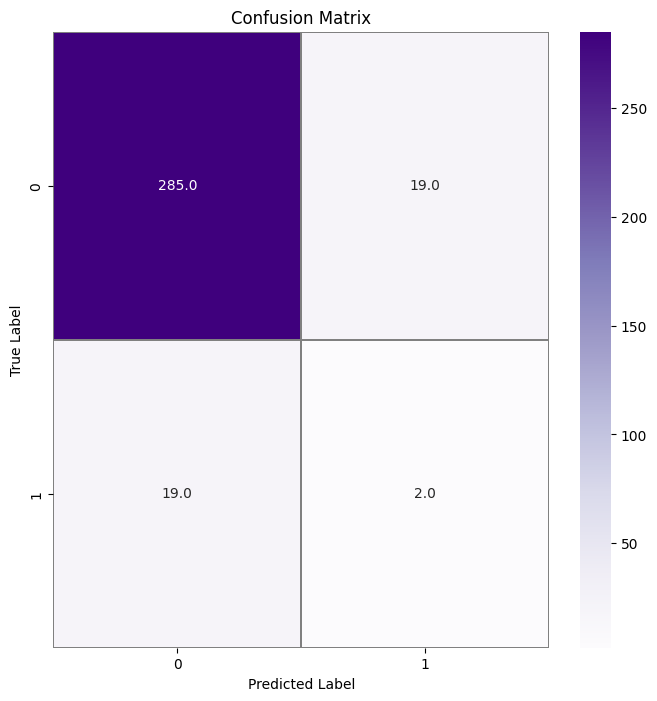

              precision    recall  f1-score   support

           0       0.94      0.94      0.94       304
           1       0.10      0.10      0.10        21

    accuracy                           0.88       325
   macro avg       0.52      0.52      0.52       325
weighted avg       0.88      0.88      0.88       325

    Model Name  Max Sensitivity at Specificity 0.94   AUC   
0  PRE_HOG_SVC                                 0.14  0.57  \

   F1-Score Positive Class  Accuracy  Sensitivity  Specificity  PPV   NPV   
0                      0.1      0.88          0.1         0.94  0.1  0.94  \

    PLR   NLR  
0  1.52  0.97  


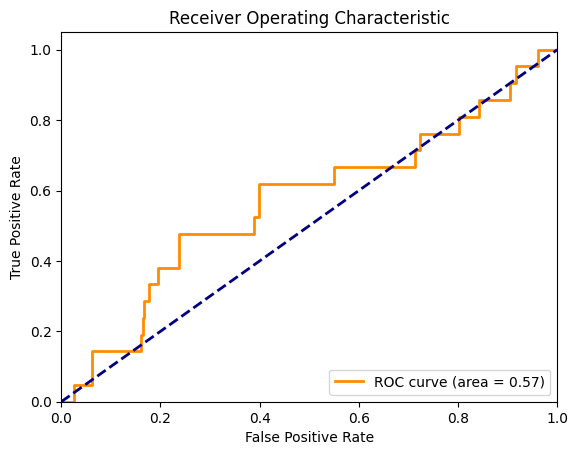

In [10]:
get_model_metrics(test_data=[X_test,y_test], model=classifier, model_name=model_name)

# XGBOOST

In [11]:
model_name = 'PRE_HOG_XGBOOST'

In [12]:
X_train = X_train_orig.copy()

In [13]:
classifier = xgb.XGBClassifier(random_state=42)
classifier.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

Max Sensitivity at Specificity >= 0.94: 0.05


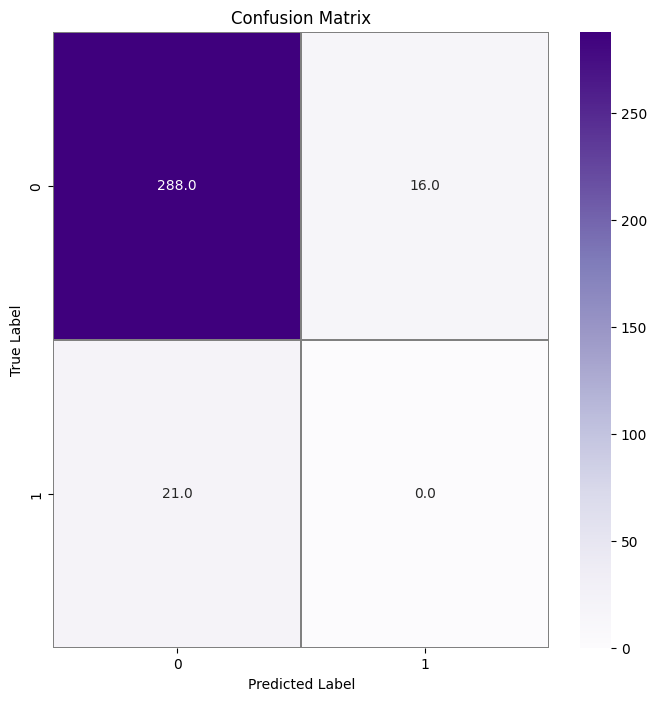

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       304
           1       0.00      0.00      0.00        21

    accuracy                           0.89       325
   macro avg       0.47      0.47      0.47       325
weighted avg       0.87      0.89      0.88       325

        Model Name  Max Sensitivity at Specificity 0.94   AUC   
0  PRE_HOG_XGBOOST                                 0.05  0.54  \

   F1-Score Positive Class  Accuracy  Sensitivity  Specificity  PPV   NPV   
0                      0.0      0.89          0.0         0.95  0.0  0.93  \

   PLR   NLR  
0  0.0  1.06  


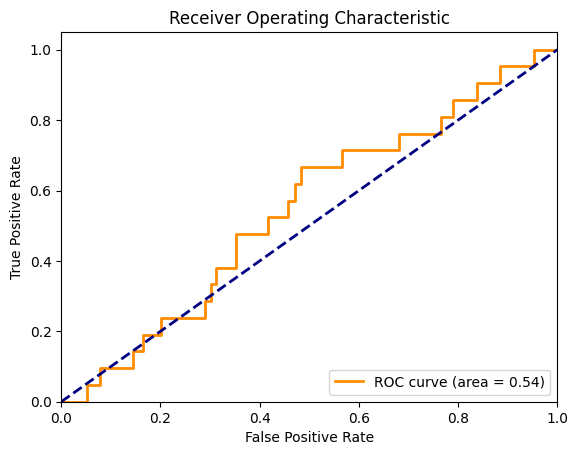

In [14]:
get_model_metrics(test_data=[X_test,y_test], model=classifier, model_name=model_name)

# LOGISTIC REGRESSION

In [15]:
model_name = 'PRE_HOG_LR'

In [16]:
classifier = LogisticRegression(random_state=42)
classifier.fit(X_train, y_train)

/Users/gcarballido/opt/miniconda3/envs/deeplearning/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

Max Sensitivity at Specificity >= 0.94: 0.10


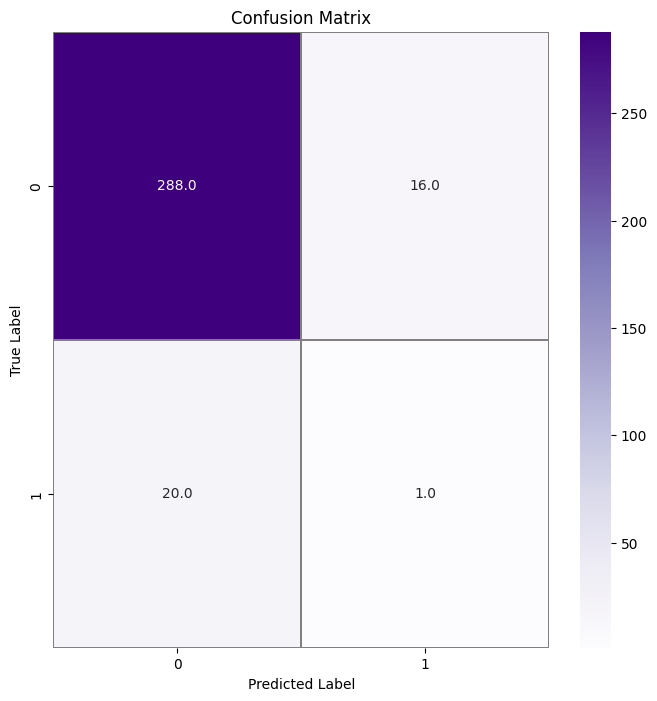

              precision    recall  f1-score   support

           0       0.94      0.95      0.94       304
           1       0.06      0.05      0.05        21

    accuracy                           0.89       325
   macro avg       0.50      0.50      0.50       325
weighted avg       0.88      0.89      0.88       325

   Model Name  Max Sensitivity at Specificity 0.94   AUC   
0  PRE_HOG_LR                                  0.1  0.47  \

   F1-Score Positive Class  Accuracy  Sensitivity  Specificity   PPV   NPV   
0                     0.05      0.89         0.05         0.95  0.06  0.94  \

   PLR   NLR  
0  0.9  1.01  


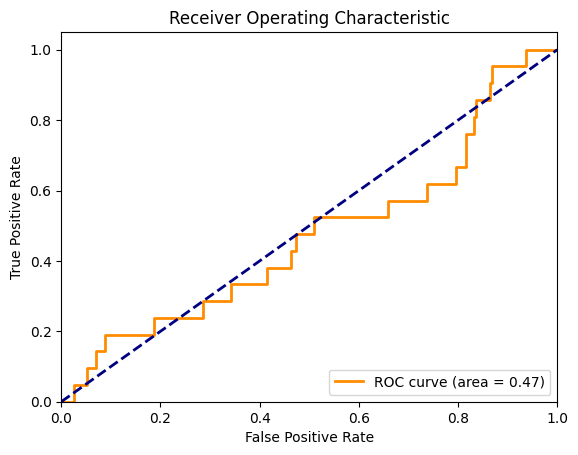

In [17]:
get_model_metrics(test_data=[X_test,y_test], model=classifier, model_name=model_name)